In [14]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier 

In [15]:
#read data
df = pd.read_csv("/kaggle/input/symptom2disease/Symptom2Disease.csv")
df.drop("Unnamed: 0",inplace=True,axis=1)
df

,label,text
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,Psoriasis,I have been experiencing joint pain in my fing...
3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,Psoriasis,"My nails have small dents or pits in them, and..."
...,...,...
1195,diabetes,I'm shaking and trembling all over. I've lost ...
1196,diabetes,"Particularly in the crevices of my skin, I hav..."
1197,diabetes,I regularly experience these intense urges and...
1198,diabetes,"I have trouble breathing, especially outside. ..."


## Get to know about data.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   1200 non-null   object
 1   text    1200 non-null   object
dtypes: object(2)
memory usage: 18.9+ KB


In [17]:
df.isnull().sum()

label    0
text     0
dtype: int64

In [18]:
for col in df.columns:
    print(col,": ",df[col].unique(),"\n")

label :  ['Psoriasis' 'Varicose Veins' 'Typhoid' 'Chicken pox' 'Impetigo' 'Dengue'
 'Fungal infection' 'Common Cold' 'Pneumonia' 'Dimorphic Hemorrhoids'
 'Arthritis' 'Acne' 'Bronchial Asthma' 'Hypertension' 'Migraine'
 'Cervical spondylosis' 'Jaundice' 'Malaria' 'urinary tract infection'
 'allergy' 'gastroesophageal reflux disease' 'drug reaction'
 'peptic ulcer disease' 'diabetes'] 

text :  ['I have been experiencing a skin rash on my arms, legs, and torso for the past few weeks. It is red, itchy, and covered in dry, scaly patches.'
 'My skin has been peeling, especially on my knees, elbows, and scalp. This peeling is often accompanied by a burning or stinging sensation.'
 'I have been experiencing joint pain in my fingers, wrists, and knees. The pain is often achy and throbbing, and it gets worse when I move my joints.'
 ...
 "I regularly experience these intense urges and the want to urinate. I frequently feel drowsy and lost. I've also significantly lost my vision."
 'I have troub

## Lets clean data

In [19]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
#set of English stop words
stop_words = set(stopwords.words('english'))

In [22]:
def clean_text(sent):
    #remove punctuations
    sent = sent.translate(str.maketrans('','',string.punctuation)).strip()
    
    #remove stopwords
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(sent)
    words = [word for word in words if word not in stop_words]
    
    return " ".join(words).lower()

In [23]:
# apply clean_text on text column of df
df["text"] = df["text"].apply(clean_text)

Vizualize text content

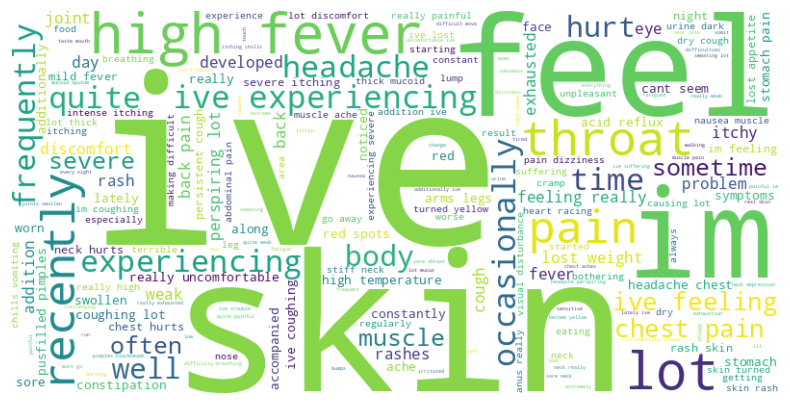

In [24]:
# create word cloud to vizualize frequent words in our dataset
all_text = " ".join(df["text"])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)


# Plotting Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Hmm!

In [26]:
#Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["label"], test_size=0.2, random_state=42)

### Text Vectorization
Here we will use Term Frequency Inverse Document Frequence(TF-IDF) method to vectorize disease symptoms description. 

In [27]:
# use tfidf for text vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1500)

tfidf_train = tfidf_vectorizer.fit_transform(X_train).toarray()
tfidf_test = tfidf_vectorizer.transform(X_test).toarray()

### Model Selection

In [29]:
# knn will be our first model 
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(tfidf_train, y_train)

KNeighborsClassifier()

In [30]:
predictions = knn.predict(tfidf_test)

In [31]:
def report(y_test,predictions):
    """Function to create classification report"""
    accuracy = accuracy_score(y_test, predictions)
    print(f'Accuracy: {accuracy:.2f}')
    print(classification_report(y_test, predictions))

In [32]:
report(y_test,predictions)

Accuracy: 0.97
                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00         7
                      Arthritis       1.00      1.00      1.00        10
               Bronchial Asthma       0.92      1.00      0.96        11
           Cervical spondylosis       1.00      1.00      1.00         7
                    Chicken pox       0.85      0.92      0.88        12
                    Common Cold       1.00      0.92      0.96        12
                         Dengue       0.79      0.92      0.85        12
          Dimorphic Hemorrhoids       1.00      1.00      1.00         7
               Fungal infection       1.00      1.00      1.00        13
                   Hypertension       1.00      1.00      1.00        10
                       Impetigo       1.00      1.00      1.00        11
                       Jaundice       1.00      1.00      1.00        11
                        Malaria    

In [34]:
def make_pred(model,text):
    """Function to make prediction on single data instance"""
    text = clean_text(text)
    tfidf = tfidf_vectorizer.transform([text]).toarray()
    disease = model.predict(tfidf)
    
    return disease[0]

Let's try our model on some real data examples.

In [37]:
symp1 = "Yellowing of skin and eyes, fatigue"
make_pred(knn,symp1)

'Jaundice'

In [38]:
symp2 = "I noticed a sudden onset of high fever, along with a rash on my skin and severe pain behind my eyes."
make_pred(knn, symp2)

'Dengue'

In [39]:
# some custom symptoms generated by Chat GPT
cust_symptoms = {
    'Psoriasis': ["I have itchy, scaly patches of skin that can be painful.", "My skin is red, inflamed, and covered in silvery scales."],
    'Varicose Veins': ["I've noticed swollen and twisted veins in my legs.", "My legs feel heavy and achy, and I have a throbbing or burning sensation."],
    'Typhoid': ["I have a high fever, abdominal pain, and a headache.", "I've experienced weakness, fatigue, and a loss of appetite."],
    'Chickenpox': ["I have itchy, red spots and blisters all over my body.", "I've had a fever and a general feeling of being unwell."],
    'Impetigo': ["I have red sores on my face that have turned into honey-colored crusts.", "I've experienced itching and oozing from these sores."],
    'Dengue': ["I've been feeling incredibly weak, with a high fever, severe headache, and excruciating joint and muscle pain.", "I noticed a sudden onset of high fever, along with a rash on my skin and severe pain behind my eyes."],
    'Fungal infection': ["I have red, itchy rashes on my skin or nails.", "My skin is peeling, cracking, or oozing, and my nails may become discolored or brittle."],
    'Common Cold': ["I have a runny or stuffy nose, coughing, sneezing, and a sore throat.", "I also feel tired, with a mild headache and a low-grade fever."],
    'Pneumonia': ["I've been coughing with yellow, green, or bloody mucus.", "I have a high fever, chills, and shortness of breath."],
    'Dimorphic Hemorrhoids': ["I have painful lumps around my anus.", "I've experienced bleeding during bowel movements and anal itching."],
    'Arthritis': ["I have joint pain, stiffness, and swelling.", "My joints are often red and warm to the touch."],
    'Acne': ["I'm getting frequent pimples, blackheads, and whiteheads.", "Sometimes I get big, red zits that hurt, and my skin is oily and easily irritated."],
    'Bronchial Asthma': ["I've been wheezing, coughing, and experiencing shortness of breath.", "My chest feels tight and I have difficulty breathing."],
    'Hypertension': ["I have high blood pressure, with no noticeable symptoms.", "Sometimes I get headaches and experience nosebleeds."],
    'Migraine': ["I have severe, throbbing headaches, often on one side of my head.", "I'm sensitive to light, sound, and sometimes experience nausea and vomiting."],
    'Cervical spondylosis': ["I have neck pain and stiffness, which can radiate to my shoulders and arms.", "I may also experience numbness or weakness in my extremities."],
    'Jaundice': ["I have yellowing of the skin and eyes.", "I've experienced fatigue, dark urine, and pale-colored stools."],
    'Malaria': ["I have recurring high fevers with chills and sweating.", "I experience fatigue, headache, and muscle aches."],
    'Urinary tract infection': ["I have a frequent urge to urinate, with a burning sensation.", "My urine is cloudy, dark, or has a strong odor."],
    'Allergy': ["I have sneezing, runny or stuffy nose, and itchy or watery eyes.", "I may also experience skin rashes or hives."],
    'Gastroesophageal reflux disease': ["I have heartburn, regurgitation of stomach acid, and a sour taste in my mouth.", "I may also experience chest pain or difficulty swallowing."],
    'Drug reaction': ["I've developed a rash, itching, or hives after taking a medication.", "I may also experience swelling of the face, lips, or tongue."],
    'Peptic ulcer disease': ["I have burning or gnawing abdominal pain, often between meals and at night.", "I may also experience bloating, burping, and nausea."],
    'Diabetes': ["I've been experiencing excessive thirst, frequent urination, and unexplained weight loss.", "I may also have blurred vision, fatigue, and slow-healing sores."],
}


In [40]:
def custom_test(model):
    c = 0
    correct_count = 0
    for dis,symptoms in cust_symptoms.items():
        for symptom in symptoms:
            c += 1
            pred = make_pred(model,symptom)
            correct = pred.lower()==dis.lower()
            if correct: correct_count += 1
            print("Actual: ",dis,"\t Pred: ",pred,"--",correct)

    print("\nTotal: ",c,"\nCorrect: ",correct_count)

In [41]:
custom_test(knn)

Actual:  Psoriasis 	 Pred:  Fungal infection -- False
Actual:  Psoriasis 	 Pred:  Psoriasis -- True
Actual:  Varicose Veins 	 Pred:  Varicose Veins -- True
Actual:  Varicose Veins 	 Pred:  Common Cold -- False
Actual:  Typhoid 	 Pred:  Jaundice -- False
Actual:  Typhoid 	 Pred:  Cervical spondylosis -- False
Actual:  Chickenpox 	 Pred:  Chicken pox -- False
Actual:  Chickenpox 	 Pred:  Malaria -- False
Actual:  Impetigo 	 Pred:  Impetigo -- True
Actual:  Impetigo 	 Pred:  Impetigo -- True
Actual:  Dengue 	 Pred:  Malaria -- False
Actual:  Dengue 	 Pred:  Dengue -- True
Actual:  Fungal infection 	 Pred:  Psoriasis -- False
Actual:  Fungal infection 	 Pred:  Psoriasis -- False
Actual:  Common Cold 	 Pred:  Common Cold -- True
Actual:  Common Cold 	 Pred:  Chicken pox -- False
Actual:  Pneumonia 	 Pred:  Pneumonia -- True
Actual:  Pneumonia 	 Pred:  Bronchial Asthma -- False
Actual:  Dimorphic Hemorrhoids 	 Pred:  Dimorphic Hemorrhoids -- True
Actual:  Dimorphic Hemorrhoids 	 Pred:  Dimor

### SVM

In [42]:
svm = SVC(kernel = 'linear', C = 1).fit(tfidf_train, y_train)
svm_pred = svm.predict(tfidf_test) 

In [43]:
report(y_test,svm_pred)

Accuracy: 0.99
                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00         7
                      Arthritis       1.00      1.00      1.00        10
               Bronchial Asthma       1.00      1.00      1.00        11
           Cervical spondylosis       1.00      1.00      1.00         7
                    Chicken pox       0.92      0.92      0.92        12
                    Common Cold       1.00      1.00      1.00        12
                         Dengue       0.92      0.92      0.92        12
          Dimorphic Hemorrhoids       1.00      1.00      1.00         7
               Fungal infection       1.00      1.00      1.00        13
                   Hypertension       1.00      1.00      1.00        10
                       Impetigo       1.00      1.00      1.00        11
                       Jaundice       1.00      1.00      1.00        11
                        Malaria    

In [44]:
make_pred(svm,symp1)

'allergy'

In [45]:
custom_test(svm)

Actual:  Psoriasis 	 Pred:  Psoriasis -- True
Actual:  Psoriasis 	 Pred:  Psoriasis -- True
Actual:  Varicose Veins 	 Pred:  Varicose Veins -- True
Actual:  Varicose Veins 	 Pred:  Psoriasis -- False
Actual:  Typhoid 	 Pred:  Typhoid -- True
Actual:  Typhoid 	 Pred:  peptic ulcer disease -- False
Actual:  Chickenpox 	 Pred:  Chicken pox -- False
Actual:  Chickenpox 	 Pred:  Bronchial Asthma -- False
Actual:  Impetigo 	 Pred:  Impetigo -- True
Actual:  Impetigo 	 Pred:  Impetigo -- True
Actual:  Dengue 	 Pred:  Dengue -- True
Actual:  Dengue 	 Pred:  Dengue -- True
Actual:  Fungal infection 	 Pred:  Psoriasis -- False
Actual:  Fungal infection 	 Pred:  Psoriasis -- False
Actual:  Common Cold 	 Pred:  Common Cold -- True
Actual:  Common Cold 	 Pred:  Chicken pox -- False
Actual:  Pneumonia 	 Pred:  Bronchial Asthma -- False
Actual:  Pneumonia 	 Pred:  Bronchial Asthma -- False
Actual:  Dimorphic Hemorrhoids 	 Pred:  Dimorphic Hemorrhoids -- True
Actual:  Dimorphic Hemorrhoids 	 Pred:  pe

### Random Forest

In [46]:
rfc = RandomForestClassifier(n_estimators = 100)
rfc.fit(tfidf_train,y_train)

RandomForestClassifier()

In [47]:
report(y_test,svm_pred)

Accuracy: 0.99
                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00         7
                      Arthritis       1.00      1.00      1.00        10
               Bronchial Asthma       1.00      1.00      1.00        11
           Cervical spondylosis       1.00      1.00      1.00         7
                    Chicken pox       0.92      0.92      0.92        12
                    Common Cold       1.00      1.00      1.00        12
                         Dengue       0.92      0.92      0.92        12
          Dimorphic Hemorrhoids       1.00      1.00      1.00         7
               Fungal infection       1.00      1.00      1.00        13
                   Hypertension       1.00      1.00      1.00        10
                       Impetigo       1.00      1.00      1.00        11
                       Jaundice       1.00      1.00      1.00        11
                        Malaria    

In [48]:
make_pred(rfc,symp1)

'Psoriasis'

In [49]:
custom_test(rfc)

Actual:  Psoriasis 	 Pred:  Fungal infection -- False
Actual:  Psoriasis 	 Pred:  Psoriasis -- True
Actual:  Varicose Veins 	 Pred:  Varicose Veins -- True
Actual:  Varicose Veins 	 Pred:  Varicose Veins -- True
Actual:  Typhoid 	 Pred:  Dengue -- False
Actual:  Typhoid 	 Pred:  Cervical spondylosis -- False
Actual:  Chickenpox 	 Pred:  Chicken pox -- False
Actual:  Chickenpox 	 Pred:  Bronchial Asthma -- False
Actual:  Impetigo 	 Pred:  Impetigo -- True
Actual:  Impetigo 	 Pred:  Impetigo -- True
Actual:  Dengue 	 Pred:  Dengue -- True
Actual:  Dengue 	 Pred:  Dengue -- True
Actual:  Fungal infection 	 Pred:  Psoriasis -- False
Actual:  Fungal infection 	 Pred:  Psoriasis -- False
Actual:  Common Cold 	 Pred:  Common Cold -- True
Actual:  Common Cold 	 Pred:  Chicken pox -- False
Actual:  Pneumonia 	 Pred:  Jaundice -- False
Actual:  Pneumonia 	 Pred:  Dengue -- False
Actual:  Dimorphic Hemorrhoids 	 Pred:  Dimorphic Hemorrhoids -- True
Actual:  Dimorphic Hemorrhoids 	 Pred:  peptic u

## Neural Networks

In [50]:
import torch
from torch import nn,optim
from torch.utils.data import DataLoader, TensorDataset

In [51]:
tfidf_train.shape

(960, 1404)

In [34]:
class ANN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, output_dim)
        

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        
        return self.fc3(x)

In [35]:
input_dim = tfidf_train.shape[1]
out_dim = 24

ann = ANN(input_dim,out_dim)

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ann.parameters(), lr=0.001)

In [37]:
diseases = df["label"].unique()

In [38]:
idx2dis = {k:v for k,v in enumerate(diseases)}
dis2idx = {v:k for k,v in idx2dis.items()}

In [39]:
y_train_int = y_train.apply(lambda x: dis2idx[x]).values
y_test_int = y_test.apply(lambda x: dis2idx[x]).values

In [40]:
X_train_tensor = torch.tensor(tfidf_train,dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_int)

X_test_tensor = torch.tensor(tfidf_test,dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_int)

In [41]:
train_dataset = TensorDataset(X_train_tensor,y_train_tensor)

In [42]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [43]:
epochs = 12
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
#         print(inputs.shape,inputs.dtype)
        optimizer.zero_grad()
        outputs = ann(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

In [44]:
text = clean_text(symp1)
tfidf = tfidf_vectorizer.transform([text]).toarray()
print(symp1)

Yellowing of skin and eyes, fatigue


In [45]:
pred = ann(torch.tensor(tfidf,dtype=torch.float32))
idx2dis[pred.argmax().item()]

'allergy'

In [46]:
pred_ann = ann(X_test_tensor).argmax(dim=1)

In [47]:
report(y_test_int,pred_ann.detach().numpy())

Accuracy: 0.99
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00         9
           3       0.92      1.00      0.96        12
           4       1.00      1.00      1.00        11
           5       0.92      0.92      0.92        12
           6       1.00      1.00      1.00        13
           7       1.00      1.00      1.00        12
           8       1.00      1.00      1.00        11
           9       1.00      1.00      1.00         7
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00         7
          12       1.00      1.00      1.00        11
          13       1.00      1.00      1.00        10
          14       1.00      1.00      1.00        10
          15       1.00      1.00      1.00         7
          16       1.00      1.00      1.00        11
          17

In [48]:
def custom_test():
    c = 0
    correct_count = 0
    
    for dis,symptoms in cust_symptoms.items():
        for symptom in symptoms:
            c += 1
            symptom = clean_text(symptom)
            tfidf = tfidf_vectorizer.transform([symptom]).toarray()
            pred = ann(torch.tensor(tfidf,dtype=torch.float32))
            pred_txt = idx2dis[pred.argmax().item()]
            correct = pred_txt.lower()==dis.lower()
            if correct: correct_count += 1
            print("Actual: ",dis,"\t Pred: ",pred_txt,"--",correct)

    print("\nTotal: ",c,"\nCorrect: ",correct_count)

In [49]:
custom_test()

Actual:  Psoriasis 	 Pred:  Psoriasis -- True
Actual:  Psoriasis 	 Pred:  Psoriasis -- True
Actual:  Varicose Veins 	 Pred:  Varicose Veins -- True
Actual:  Varicose Veins 	 Pred:  allergy -- False
Actual:  Typhoid 	 Pred:  Typhoid -- True
Actual:  Typhoid 	 Pred:  Cervical spondylosis -- False
Actual:  Chickenpox 	 Pred:  Chicken pox -- False
Actual:  Chickenpox 	 Pred:  Bronchial Asthma -- False
Actual:  Impetigo 	 Pred:  Impetigo -- True
Actual:  Impetigo 	 Pred:  Impetigo -- True
Actual:  Dengue 	 Pred:  Dengue -- True
Actual:  Dengue 	 Pred:  Dengue -- True
Actual:  Fungal infection 	 Pred:  Psoriasis -- False
Actual:  Fungal infection 	 Pred:  Psoriasis -- False
Actual:  Common Cold 	 Pred:  Common Cold -- True
Actual:  Common Cold 	 Pred:  Chicken pox -- False
Actual:  Pneumonia 	 Pred:  Bronchial Asthma -- False
Actual:  Pneumonia 	 Pred:  Bronchial Asthma -- False
Actual:  Dimorphic Hemorrhoids 	 Pred:  Dimorphic Hemorrhoids -- True
Actual:  Dimorphic Hemorrhoids 	 Pred:  Dimo

Better than before, but still the symptoms generated from ChatGPT are different from those in our dataset. We need to train on more diverse dataset to do better. 

## Sequence Models
In another Notebook

In [50]:
words = df["text"].str.split().apply(len)
print("Average words: ",int(words.mean()))
print("Max words: ",int(words.max()))

Average words:  18
Max words:  31
